# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import torch
import numpy as np
import math
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
import keras.backend as K
import matplotlib.pyplot as plt
import os
from scipy.io import savemat
from scipy.io import loadmat
import seaborn as sns

tf.enable_v2_behavior()



builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Google Drive Connect



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data loading

In [3]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model creation

In [4]:
#test {"output": "ignore"}

# Build CNN teacher.
def build_cnn_model():
  cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
  cnn_model.add(Conv2D(32,(3,3),strides=1,activation="relu"))
  cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=1))
  cnn_model.add(Conv2D(64,(3,3),strides=1,activation="relu"))
  cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=2))
  cnn_model.add(Flatten())
  cnn_model.add(Dropout(0.5))
  cnn_model.add(Dense(128,activation="relu")) 
  cnn_model.add(Dropout(0.5))
  cnn_model.add(Dense(10)) 
  return cnn_model

def build_fc_model():
# Build fully connected student.
  fc_model = tf.keras.Sequential()


# your code start from here for step 2
  fc_model.add(Flatten())
  fc_model.add(Dense(784,activation="relu")) 
  fc_model.add(Dense(784,activation="relu")) 
  fc_model.add(Dense(10)) 
  return fc_model


# Teacher loss function

In [5]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels,subclass_logits)


  return cross_entropy_loss_value

# Student loss function

In [6]:
#test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.4 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 32. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3
  teacher_subclass_logits = cnn_model(images, training=False)
  
  distillation_loss_value = distillation_loss(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels,tf.nn.softmax(student_subclass_logits))

  return (ALPHA*distillation_loss_value+(1-ALPHA)*cross_entropy_loss_value)

# Train and evaluation

In [7]:
#tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
  accuracy = []
  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      #print(compute_num_correct(model,images,labels))
      num_correct += (compute_num_correct(model,images,labels)[0])
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    accuracy.append(num_correct / num_total *100)
  return accuracy


# Training models

In [8]:
# your code start from here for step 5 
# Train the teacher model
cnn_model = build_cnn_model()
accuracy_T = train_and_evaluate(cnn_model,compute_teacher_loss)

Epoch 1: Class_accuracy: 98.31%
Epoch 2: Class_accuracy: 98.70%
Epoch 3: Class_accuracy: 98.93%
Epoch 4: Class_accuracy: 99.04%
Epoch 5: Class_accuracy: 98.90%
Epoch 6: Class_accuracy: 99.07%
Epoch 7: Class_accuracy: 99.13%
Epoch 8: Class_accuracy: 99.06%
Epoch 9: Class_accuracy: 99.25%
Epoch 10: Class_accuracy: 99.21%
Epoch 11: Class_accuracy: 99.24%
Epoch 12: Class_accuracy: 99.26%


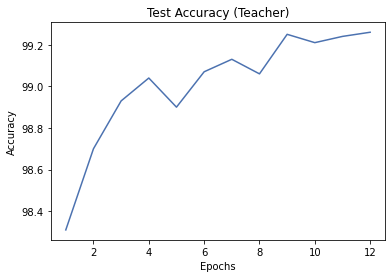

In [53]:
# Plot the accuracy_T vs. epochs curve
color_list = sns.color_palette('deep')
plt.plot(range(1,NUM_EPOCHS+1),accuracy_T,color = color_list[0])
plt.title('Test Accuracy (Teacher)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# Save the accuracy_T vs. epochs curve and data
os.chdir('/content/drive/MyDrive/Task1/Figs')
plt.savefig('Test_Accuracy_T.jpg')
os.chdir('/content/drive/MyDrive/Task1/Results')
T_dict={'NUM_EPOCHS':NUM_EPOCHS, 'accuracy_T':accuracy_T}
savemat('accuracy_T.mat',T_dict)


In [33]:
# Train the student model
ALPHA = 0.4
DISTILLATION_TEMPERATURE = 4
fc_model=build_fc_model()
accuracy_S_KD = train_and_evaluate(fc_model,compute_student_loss)

Epoch 1: Class_accuracy: 96.77%
Epoch 2: Class_accuracy: 97.84%
Epoch 3: Class_accuracy: 98.20%
Epoch 4: Class_accuracy: 98.43%
Epoch 5: Class_accuracy: 98.55%
Epoch 6: Class_accuracy: 98.73%
Epoch 7: Class_accuracy: 98.72%
Epoch 8: Class_accuracy: 98.69%
Epoch 9: Class_accuracy: 98.82%
Epoch 10: Class_accuracy: 98.82%
Epoch 11: Class_accuracy: 98.82%
Epoch 12: Class_accuracy: 98.84%


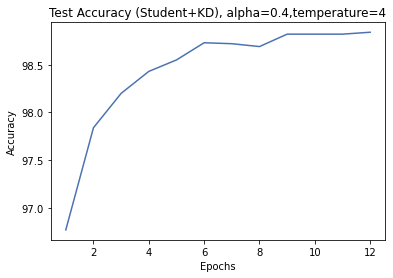

In [54]:
# Plot the accuracy_S_KD vs. epochs curve
plt.plot(range(1,NUM_EPOCHS+1),accuracy_S_KD,color = color_list[0])
plt.title('Test Accuracy (Student+KD), alpha=0.4,temperature=4')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# Save the accuracy_S_KD vs. epochs curve and data
os.chdir('/content/drive/MyDrive/Task1/Figs')
plt.savefig('Test_Accuracy_S_KD.jpg')
os.chdir('/content/drive/MyDrive/Task1/Results')
S_KD_dict={'NUM_EPOCHS':NUM_EPOCHS, 'accuracy_S_KD':accuracy_S_KD}
savemat('accuracy_S_KD.mat',S_KD_dict)


# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6
ACC = []
ALPHA = 0.5
temperatures = [1,2,4,16,32,64]
for temperature in temperatures:
  DISTILLATION_TEMPERATURE = temperature
  fc_model=build_fc_model()
  accuracy = train_and_evaluate(fc_model,compute_student_loss)
  ACC.append(accuracy[-1])
  print(ACC)
accuracy_S_KD = ACC

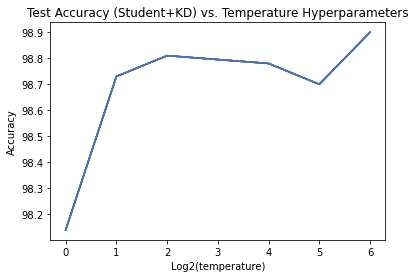

In [56]:
# Plot the accuracy_S vs. temperatures curve
log2_temperatures = [math.log2(x) for x in temperatures]
for i, temperature in enumerate(temperatures):
  plt.plot(log2_temperatures,accuracy_S_KD,color = color_list[0])
plt.title('Test Accuracy (Student+KD) vs. Temperature Hyperparameters')
plt.xlabel('Log2(temperature)')
plt.ylabel('Accuracy')


# Save the accuracy_S curve vs. temperatures curve and data
os.chdir('/content/drive/MyDrive/Task1/Figs')
plt.savefig('Test_Accuracy_S_KD__vs_Temp.jpg')
os.chdir('/content/drive/MyDrive/Task1/Results')
S_KD_dict={'temperatures':temperatures, 'accuracy_S_KD':accuracy_S_KD}
savemat('accuracy_S_KD_vs_Temp.mat',S_KD_dict)

# Test accuracy vs. alpha and tempreture curve

In [ ]:
ACC = np.zeros([8,7])
temperatures = [1,2,4,16,32,64,128]
alphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
for i, alpha in enumerate(alphas):
  for j, temperature in enumerate(temperatures):
    ALPHA = alpha
    DISTILLATION_TEMPERATURE = temperature
    fc_model=build_fc_model()
    accuracy = train_and_evaluate(fc_model,compute_student_loss)
    ACC[i,j] = (accuracy[-1])
    print(ACC)
accuracy_S_KD_T_alpha = ACC

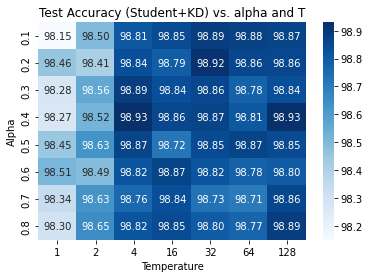

In [62]:
# Plot the accuracy_S vs. alphas and temperatures curve
plt.figure()
ax = sns.heatmap(accuracy_S_KD_T_alpha,annot=True,fmt=".2f",xticklabels=temperatures,yticklabels=alphas,cmap="Blues")
ax.set_xlabel("Temperature")
ax.set_ylabel("Alpha")
ax.set_title("Test Accuracy (Student+KD) vs. alpha and T")

# Save the accuracy_S curve vs. alphas and temperatures curve and data
os.chdir('/content/drive/MyDrive/Task1/Figs')
heatmap = ax.get_figure()
heatmap.savefig('Test_Accuracy_S_KD__vs_Temp_alpha.jpg')
os.chdir('/content/drive/MyDrive/Task1/Results')
S_KD_T_alpha_dict={'temperatures':temperatures,'alphas':alphas,'accuracy_S_KD_T_alpha':accuracy_S_KD_T_alpha}
savemat('accuracy_S_KD_vs_Temp_alpha.mat',S_KD_T_alpha_dict)

# Train student from scratch

In [50]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7
# fc_model_no_distillation.add(Flatten())
# fc_model_no_distillation.add(Dense(784)) 
# fc_model_no_distillation.add(Activation("relu"))
# fc_model_no_distillation.add(Dense(784)) 
# fc_model_no_distillation.add(Activation("relu"))
# fc_model_no_distillation.add(Dense(10)) 

fc_model_no_distillation = build_fc_model()


#test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels,tf.nn.softmax(student_subclass_logits))
  
  return cross_entropy_loss


accuracy_S = train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 95.20%
Epoch 2: Class_accuracy: 96.43%
Epoch 3: Class_accuracy: 96.98%
Epoch 4: Class_accuracy: 96.69%
Epoch 5: Class_accuracy: 97.51%
Epoch 6: Class_accuracy: 97.43%
Epoch 7: Class_accuracy: 97.68%
Epoch 8: Class_accuracy: 97.80%
Epoch 9: Class_accuracy: 97.43%
Epoch 10: Class_accuracy: 97.50%
Epoch 11: Class_accuracy: 97.66%
Epoch 12: Class_accuracy: 97.85%


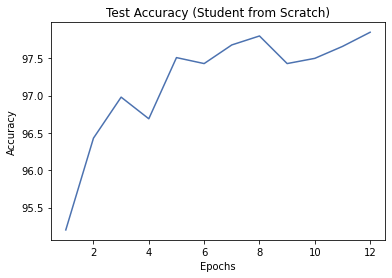

In [52]:
# Plot the accuracy_S vs. epochs curve
os.chdir('/content/drive/MyDrive/Task1/Figs')
plt.plot(range(1,NUM_EPOCHS+1),accuracy_S,color=color_list[0])
plt.title('Test Accuracy (Student from Scratch)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Save the accuracy_S vs. epochs curve and data
plt.savefig('Test_Accuracy_S.jpg')
os.chdir('/content/drive/MyDrive/Task1/Results')
S_dict = {'NUM_EPOCHS':NUM_EPOCHS, 'accuracy_S':accuracy_S}
savemat('accuracy_S.mat',S_dict)

# Comparing the teacher and student model (number of of parameters and FLOPs) 

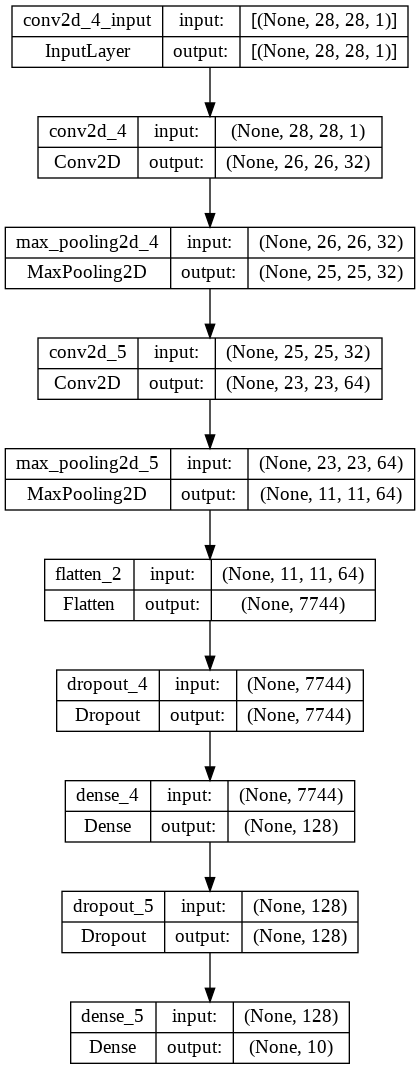

In [ ]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 23, 23, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                    

In [ ]:
fc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               615440    
                                                                 
 activation_3 (Activation)   (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 784)               615440    
                                                                 
 activation_4 (Activation)   (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
No

In [ ]:
fc_model_no_distillation.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_11 (Dense)            (None, 784)               615440    
                                                                 
 activation_9 (Activation)   (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 784)               615440    
                                                                 
 activation_10 (Activation)  (None, 784)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
No

# Implementing the state-of-the-art KD algorithm

In [35]:
from tensorflow import float32
def distillation_loss_EX(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor], epsilon, T_s):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature)
  # print(soft_targets)
  # u = tf.reduce_sum(soft_targets,1,keepdims=True) / 10.0
  # print(u)
  u = tf.ones_like(soft_targets) / 10.0
  # print(u.shape)
  u=0
  zeros = tf.zeros_like(soft_targets)
  # print(zeros.shape)
  distinc_prob = tf.math.maximum(soft_targets-u, zeros)
  # print(distinc_prob.shape)
  norm_fact = tf.reduce_sum(distinc_prob,1,keepdims=True)

  distinc_prob_norm = distinc_prob / norm_fact
  prob = (1-epsilon)*distinc_prob_norm + epsilon*u

  return tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        prob, student_logits / T_s))

  # return tf.reduce_mean(
  #     tf.nn.softmax_cross_entropy_with_logits(
  #         soft_targets, student_logits / temperature)) #* temperature ** 2


In [36]:
#test {"output": "ignore"}

def compute_student_loss_EX(images, labels, epsilon, T_s):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model_EX(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3
  teacher_subclass_logits = cnn_model(images, training=False)
  
  distillation_loss_value = distillation_loss_EX(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE,epsilon,T_s)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels,tf.nn.softmax(student_subclass_logits))

  return (BEITA*T_s*distillation_loss_value+GAMMA*cross_entropy_loss_value)

In [37]:
# your code start from here for step 12
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)
              
def train_and_evaluate_EX(model, compute_loss_fn, NUM_EPOCHS, epsilon, T_s):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
  accuracy = []
  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images, labels, epsilon, T_s)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      #print(compute_num_correct(model,images,labels))
      num_correct += (compute_num_correct(model,images,labels)[0])
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    accuracy.append(num_correct / num_total *100)
  return accuracy

In [ ]:
# your code start from here for step 6
ACC = np.zeros([7,7])
temperatures = [1,2,4,16,32,64,128]
for i, T_s in enumerate(temperatures):
  for j, T_t in enumerate(temperatures):
    DISTILLATION_TEMPERATURE = T_t
    fc_model_EX = build_fc_model()
    accuracy = train_and_evaluate_EX(fc_model_EX,compute_student_loss_EX,12,0,T_s)
    ACC[i,j] = (accuracy[-1])
    print(ACC)
accuracy_S_EX_Ts_Tt = ACC

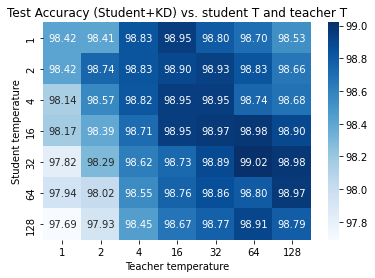

In [63]:
# Plot the accuracy_S_KD+ vs. alphas and temperatures curve
plt.figure()
ax = sns.heatmap(accuracy_S_EX_Ts_Tt,annot=True,fmt=".2f",xticklabels=temperatures,yticklabels=temperatures,cmap="Blues")
ax.set_xlabel("Teacher temperature")
ax.set_ylabel("Student temperature")
ax.set_title("Test Accuracy (Student+KD) vs. student T and teacher T")

# Save the accuracy_S curve vs. alphas and temperatures curve and data
os.chdir('/content/drive/MyDrive/Task1/Figs')
heatmap = ax.get_figure()
heatmap.savefig('Test_Accuracy_S_EX__vs_Temps.jpg')
os.chdir('/content/drive/MyDrive/Task1/Results')
S_EX_Ts_dict={'temperatures':temperatures,'accuracy_S_EX_Ts_Tt':accuracy_S_EX_Ts_Tt}
savemat('accuracy_S_EX_vs_Temps.mat',S_EX_Ts_dict)

In [48]:

# 3.6 0.1 4 0.2 98.76
# 3.6 0.1 4 0.1 98.78

# 15 0.8 64 8 99.0
# 
BEITA = 1.6
GAMMA = 0.6
DISTILLATION_TEMPERATURE = 64
fc_model_EX = build_fc_model()
accuracy_S_EX = train_and_evaluate_EX(fc_model_EX,compute_student_loss_EX,12,0,32)

Epoch 1: Class_accuracy: 97.53%
Epoch 2: Class_accuracy: 98.22%
Epoch 3: Class_accuracy: 98.42%
Epoch 4: Class_accuracy: 98.64%
Epoch 5: Class_accuracy: 98.71%
Epoch 6: Class_accuracy: 98.78%
Epoch 7: Class_accuracy: 98.79%
Epoch 8: Class_accuracy: 98.93%
Epoch 9: Class_accuracy: 98.88%
Epoch 10: Class_accuracy: 98.91%
Epoch 11: Class_accuracy: 99.04%
Epoch 12: Class_accuracy: 99.02%


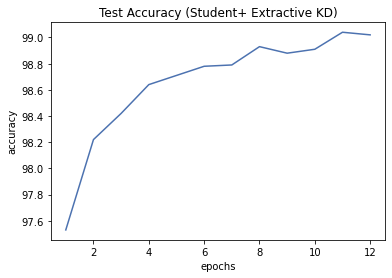

In [64]:
# Plot the accuracy_S_KD vs. epochs curve
plt.plot(range(1,NUM_EPOCHS+1),accuracy_S_EX,color = color_list[0])
plt.title('Test Accuracy (Student+ Extractive KD)')
plt.xlabel('epochs')
plt.ylabel('accuracy')


# Save the accuracy_S_KD vs. epochs curve and data
os.chdir('/content/drive/MyDrive/Task1/Figs')
plt.savefig('Test_Accuracy_S_EX.jpg')
os.chdir('/content/drive/MyDrive/Task1/Results')
S_EX_dict={'NUM_EPOCHS':NUM_EPOCHS, 'accuracy_S_EX':accuracy_S_EX}
savemat('accuracy_S_EX.mat',S_EX_dict)

# (Optional) XAI method to explain models

In [ ]:
# your code start from here for step 13
